Here we load and combine the relevant data regarding the location and seasonal covariate for each sample 

In [1]:
data_dir = "/Volumes/KeithSSD/ChesapeakeMicrobiome/data/environmental_raw_data"

txm_file = 'Transformed_WQVars_Hab_and_aDiv.txt'
orig_file = 'merged_paired_water_quality_data.txt'

txm_data <- read.delim(paste(data_dir, txm_file, sep="/"), row.names=1)
orig_data <- read.delim(paste(data_dir, orig_file, sep="/"), row.names=1)

meta_data = data.frame('Seasonality.Continuous'=orig_data[,'FallPeak'],
                       'Latitude'=orig_data[,'Latitude'],
                       'Years'=orig_data[,'LinearTime'])
rownames(meta_data) <- rownames(orig_data)
meta_data[rownames(orig_data),'StationGroup'] = txm_data[rownames(orig_data),'StatName']

To convert the continuous seasonal variable into a factor to formulate time/place combinations, we want to visualize obvious breakpoints and resulting group sizes.


  (-1,-0.5] (-0.5,0.25]  (0.25,0.5]  (0.5,0.85] (0.85,1.05] 
         49          28          44          52          63 


 1  2  3  4  5 
49 28 44 52 63 

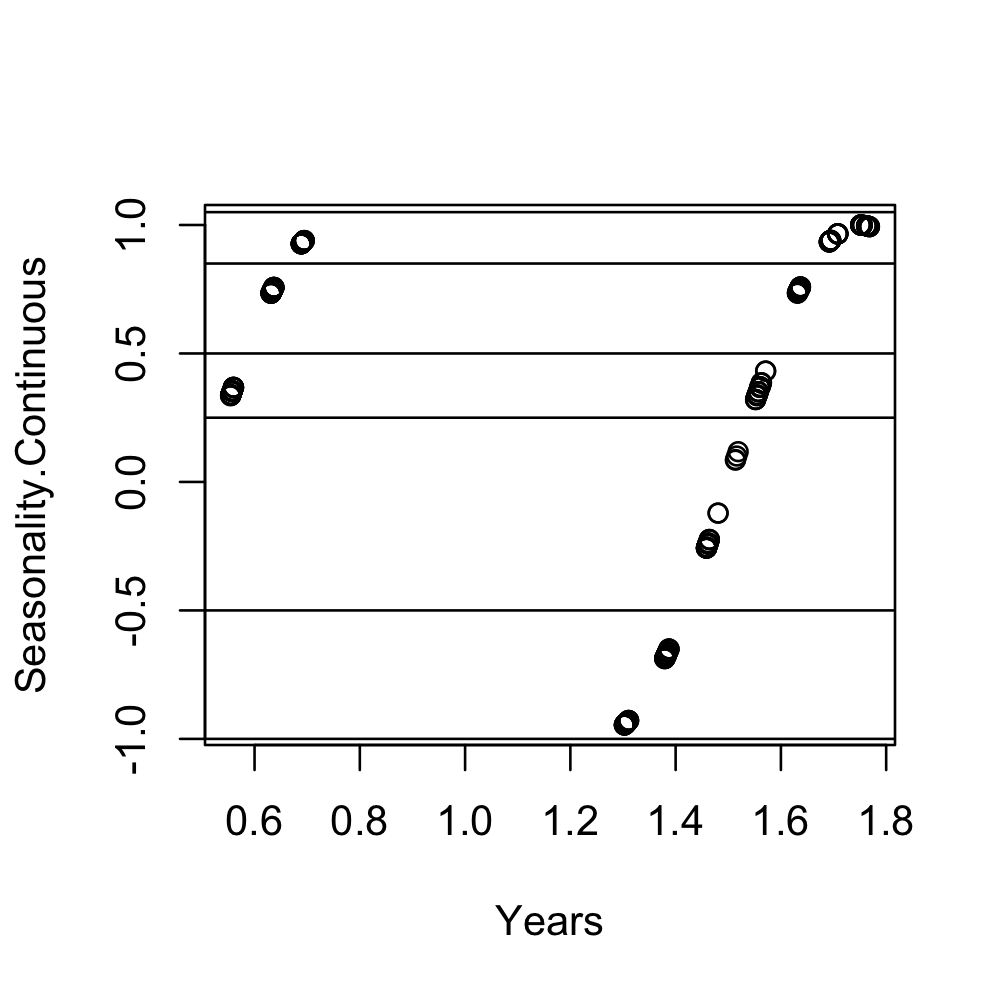

In [2]:
options(repr.plot.width=4, repr.plot.height=4, repr.plot.res=250)
with(meta_data, plot(Years, Seasonality.Continuous, xlab='Time elapsed since Dec-22-2015 (years)'))
abline(h=c(1.05, 0.85, 0.5, 0.25, -0.5, -1))

table(cut(meta_data$Seasonality.Continuous, c(1.05, 0.85, 0.5, 0.25, -0.5, -1)))
meta_data$Seasonality = cut(meta_data$Seasonality.Continuous, c(1.05, 0.85, 0.5, 0.25, -0.5, -1))
meta_data$Seasonality = factor(as.integer(meta_data$Seasonality))
table(meta_data$Seasonality)


Here we make all possible combinations of sampling times

In [3]:
sample_times = base::sort(unique(meta_data$Seasonality))

times_ = matrix(nrow = 5000, ncol = length(sample_times))
colnames(times_) <- paste('T', 1:length(sample_times), sep=".")
rownames(times_) <- paste('time', 1:5000, sep=".")

counter = 0
for (grp_size in 1:length(sample_times)){
    print(grp_size)
    grps = t(combn(sample_times, grp_size))
    print(dim(grps))
    for (row_n in 1:dim(grps)[1]){
        counter = counter + 1
        times_[counter,grps[row_n,]] = 1
    }
}

times_[is.na(times_)] = 0
times_ = times_[-which(rowSums(times_) == 0),]
dim(times_)

[1] 1
[1] 5 1
[1] 2
[1] 10  2
[1] 3
[1] 10  3
[1] 4
[1] 5 4
[1] 5
[1] 1 5


[1] 31  5

Here we make all possible combinations of sampling locations

In [4]:
places = matrix(nrow = 5000, ncol = length(unique(meta_data$StationGroup)))
colnames(places) <- paste('P', 1:length(unique(meta_data$StationGroup)), sep=".")
rownames(places) <- paste('place', 1:5000, sep=".")


station_grps = base::sort(unique(meta_data$StationGroup))
counter = 0
for (grp_size in station_grps){
    print(grp_size)
    grps = t(combn(station_grps, grp_size))
    print(dim(grps))
    for (row_n in 1:dim(grps)[1]){
        counter = counter + 1
        places[counter,grps[row_n,]] = 1
    }
}

places[is.na(places)] = 0
places = places[-which(rowSums(places) == 0),]
dim(places)

[1] 1
[1] 7 1
[1] 2
[1] 21  2
[1] 3
[1] 35  3
[1] 4
[1] 35  4
[1] 5
[1] 21  5
[1] 6
[1] 7 6
[1] 7
[1] 1 7


[1] 127   7

Here we combine them in a pairwise fashion and we create a pair of colums for the purposes of identifying perfect opposites (e.g. OTUs that have positive non-zero coefficients for a time/place response for station 1 at time 1 should have negative coefficients non-zero for a response indicating stations 2-7 at times 2-5)

In [5]:
times_places = matrix(nrow=nrow(places)*nrow(times_), 
                      ncol=ncol(places)+ncol(times_))

colnames(times_places) <- c(colnames(places), colnames(times_))
combo_rn = c()
combo_counter = 1
for (p_r in rownames(places)){
    for (t_r in rownames(times_)){
        combo_rn = c(combo_rn, paste(p_r, t_r, sep="_"))
        times_places[combo_counter, colnames(places)] = places[p_r,]
        times_places[combo_counter, colnames(times_)] = times_[t_r,]
        combo_counter = combo_counter + 1
    }
}
rownames(times_places) <- combo_rn
dim(times_places)
dim(unique(times_places))
old_names <- colnames(times_places)
times_places = cbind(times_places, apply(times_places, 1, paste, collapse=""), 
                     apply(abs(times_places - 1) , 1, paste, collapse=""))

colnames(times_places) <- c(old_names, 'binstring', 'opp.binstring')
head(times_places)

[1] 3937   12

[1] 3937   12

,P.1,P.2,P.3,P.4,P.5,P.6,P.7,T.1,T.2,T.3,T.4,T.5,binstring,opp.binstring
place.1_time.1,1,0,0,0,0,0,0,1,0,0,0,0,100000010000,011111101111
place.1_time.2,1,0,0,0,0,0,0,0,1,0,0,0,100000001000,011111110111
place.1_time.3,1,0,0,0,0,0,0,0,0,1,0,0,100000000100,011111111011
place.1_time.4,1,0,0,0,0,0,0,0,0,0,1,0,100000000010,011111111101
place.1_time.5,1,0,0,0,0,0,0,0,0,0,0,1,100000000001,011111111110
place.1_time.6,1,0,0,0,0,0,0,1,1,0,0,0,100000011000,011111100111


This adds a column where the kinds of pairings described above can be identified 

In [6]:
pair_list = list()
for (idx in 1:nrow(times_places)){
    t_p = rownames(times_places)[idx]
    animus = times_places[t_p, 'binstring']
    anima = times_places[, 'opp.binstring'] == animus
    if (sum(anima) > 0){
        p_t = names(which(anima))[1]
        doublet = sort(c(t_p, p_t))
        if (doublet[2] == t_p){
            pair_list[[idx]] = NA
        } else {
            pair_list[[idx]] = doublet[2]
        }
    } else {
        pair_list[[idx]] = 'unique'
    }
}

times_places = cbind(times_places, unlist(pair_list))
colnames(times_places)[colnames(times_places) == ''] <- 'setting_match'
length(which(times_places[,'setting_match'] == 'unique'))
sum(is.na(times_places[,'setting_match']))
head(times_places, 3)

[1] 157

[1] 1890

,P.1,P.2,P.3,P.4,P.5,P.6,P.7,T.1,T.2,T.3,T.4,T.5,binstring,opp.binstring,setting_match
place.1_time.1,1,0,0,0,0,0,0,1,0,0,0,0,100000010000,011111101111,place.126_time.30
place.1_time.2,1,0,0,0,0,0,0,0,1,0,0,0,100000001000,011111110111,place.126_time.29
place.1_time.3,1,0,0,0,0,0,0,0,0,1,0,0,100000000100,011111111011,place.126_time.28


Here we take the columns that aren't NA from the above `times_places` object and create a matrix of binary responses. We also filter out any time/place combinations that have fewer than 12 supporting samples. This is because of our need to split the data into test/train sets (by a 3:1 ratio) to evaluate the model & the minimum of 8 samples per factor level for logisitc ridge regression. 

In [7]:
statN = length(unique(meta_data$StationGroup))
seasN = length(unique(meta_data$Seasonality))
print(c(statN, seasN))
response_set = matrix(0, ncol=nrow(times_places), nrow=nrow(meta_data),
                     dimnames=list(rownames(meta_data), rownames(times_places)))

for (t_p in rownames(times_places)){
    stat_bool = as.logical(as.integer(times_places[t_p,1:statN]))
    ssnlty_bool = as.logical(as.integer(times_places[t_p,(statN+1):(statN+seasN)]))
    accepted_statnames = (1:statN)[stat_bool]
    accepted_season = (1:seasN)[ssnlty_bool]
    ones_ = (meta_data$Seasonality %in% accepted_season) & (meta_data$StationGroup %in% accepted_statnames)
    response_set[which(ones_), t_p] = 1
}
dim(response_set)
response_setx = response_set[,(colSums(response_set) > 12) & (colSums(response_set) < 224)]
dim(response_setx)
table(colSums(response_setx))

[1] 7 5


[1]  236 3937

[1]  236 3773


 13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32 
 24  37  29  35  32  36  50  35  37  47  38  48  38  39  40  54  46  49  44  35 
 33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52 
 47  44  52  44  43  54  41  43  48  46  43  43  39  57  46  35  39  50  41  45 
 53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72 
 44  37  46  46  38  48  30  47  39  37  29  46  33  42  37  34  34  39  35  41 
 73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92 
 33  30  30  22  37  36  26  33  28  27  26  22  28  26  33  29  21  20  21  19 
 93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 
 27  28  21  25  19   9  21  17  17  26  15  15  17  18  21  17  12   9  10  18 
113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 
 14   8  15  11  15  16  12   4  14  11   7  12   9   6  12   7  11   7   9   8 
133 134 135 136 137 138 139

These plots are included to show the combined temporal/spatial coverage (i.e. the row sum from P1 to T5) of time-place combinations removed for lack of samples. It shows we lost roughly 17% to 25% of the more localized and/or ephemeral possibilities (i.e. a row-sum of 2 or 3) in exchange for greater confidence in the ultimate results.

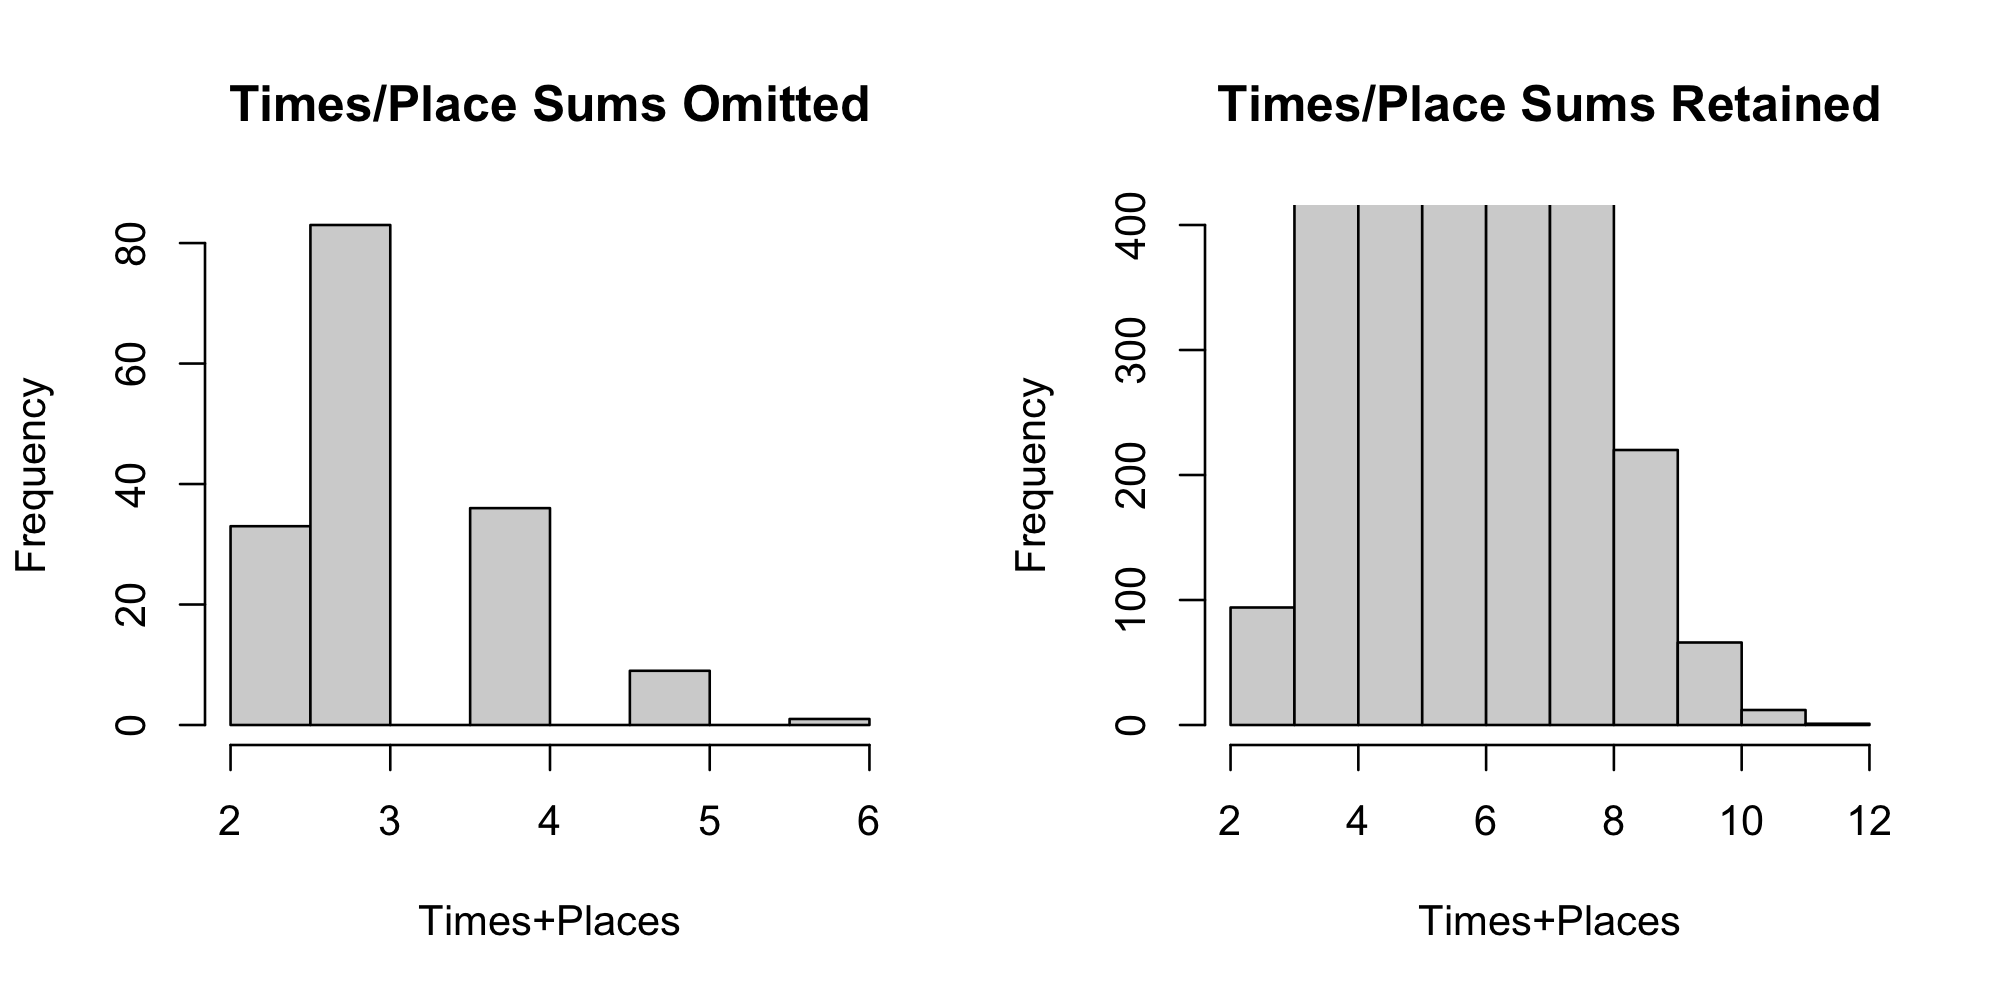

In [8]:
options(repr.plot.width=8, repr.plot.height=4, repr.plot.res=250)
tps_skipped = colnames(response_set)[colSums(response_set) <= 12]
tps_kept = colnames(response_set)[colSums(response_set) > 12]
par(mfrow=c(1,2))
hist(rowSums(apply(times_places[tps_skipped,1:12], MAR=2, as.integer)), xlab='Times+Places', 
     main='Times/Place Sums Omitted')
hist(rowSums(apply(times_places[tps_kept,1:12], MAR=2, as.integer)), xlab='Times+Places',
     ylim=c(0, 400), main='Times/Place Sums Retained')

Here's where we read in the abundance data and create a template object for storing coefficients and accuracy scores of each regression.

In [9]:
suppressPackageStartupMessages(library(compositions))
suppressPackageStartupMessages(library(zCompositions))

oeu_abund_file = "/Volumes/KeithSSD/ChesapeakeMicrobiome/data/oeu_clusters/oeu_abundances.txt"
oeu_df = read.delim(oeu_abund_file, row.names=1, sep="\t")
oeu_df = oeu_df[rownames(meta_data),]
oeu_df = oeu_df[which(rowSums(oeu_df) > 0), which(colSums(oeu_df) > 0)]
ra_oeu_df <- clr(cmultRepl(oeu_df, method="CZM", output="p-counts"))
coeff_cols = c('(Intercept)', 'coef.pos.n', 'coef.pos.mean', 'coef.neg.n', 'coef.neg.mean', 'acc',
               colnames(ra_oeu_df))
coeff_rows <- colnames(response_setx)
oeu_fit_results = matrix(NA, ncol=length(coeff_cols), nrow=length(coeff_rows))
dim(oeu_fit_results)
colnames(oeu_fit_results) <- coeff_cols
rownames(oeu_fit_results) <- coeff_rows

[1] 3773  134

Here we load the vegan package for use in creating three randomized permuations of the abundance table. First we convert the scaled relative abundances to integers. It probably would have been smarter to set `times=3` and save the results as an RData file, but I didn't envision retesting against different permutations.

In [10]:
library(vegan)
int_oeu_df = apply(apply(oeu_df, MAR=1, FUN=round), MAR=1, FUN=as.integer)
rownames(int_oeu_df) <- rownames(oeu_df)

out_dir = '/Volumes/KeithSSD/ChesapeakeMicrobiome/data/time_place_analysis/'
perm_tables = list()
perm_outputs = list()

for (perm_i in 1:3){
    pfilename = paste(out_dir, 'permuted_tablev', perm_i, '.txt', sep='')
    if (file.exists(pfilename)) {
        print(paste('Reading table', perm_i)); flush.console();
        perm_table_i = read.delim(pfilename, row.names=1)
    } else {
        set.seed(perm_i)
        print(paste('Generating table', perm_i)); flush.console();
        perm_obj = permatswap(int_oeu_df, times=1)
        perm_table_i = perm_obj$perm[[1]]
        write.table(perm_table_i, file=pfilename, sep="\t")
    }
    ra_perm_df <- clr(cmultRepl(perm_table_i, method="CZM", output="p-counts"))
    perm_cols = c('(Intercept)', 'coef.pos.n', 'coef.pos.mean', 'coef.neg.n', 'coef.neg.mean', 'acc',
                   colnames(ra_perm_df))
    perm_tables[[perm_i]] = perm_table_i
    perm_results = matrix(NA, ncol=length(perm_cols), nrow=length(coeff_rows))
    colnames(perm_results) <- perm_cols
    rownames(perm_results) <- coeff_rows
    perm_outputs[[perm_i]] <- cbind(perm_results)
}



Loading required package: permute

Loading required package: lattice

This is vegan 2.5-6



[1] "Reading table 1"
[1] "Reading table 2"
[1] "Reading table 3"


In [11]:
names(perm_tables) <- paste('Perm', 1:length(perm_tables), sep=".")
names(perm_tables)
names(perm_outputs) <- paste('Perm', 1:length(perm_outputs), sep=".")
names(perm_outputs)


[1] "Perm.1" "Perm.2" "Perm.3"

[1] "Perm.1" "Perm.2" "Perm.3"

In [13]:
suppressPackageStartupMessages(library(caret))
coeff_file = '/Volumes/KeithSSD/ChesapeakeMicrobiome/data/time_place_analysis/final_TP_coefficients.RData'
predictor_sets = list('OEU'=cbind(ra_oeu_df))
results_tables = list('OEU'=cbind(oeu_fit_results))
for (prmN in names(perm_outputs)){
    predictor_sets[[prmN]] = perm_tables[[prmN]]; 
    results_tables[[prmN]] = perm_outputs[[prmN]];
}
predictor_sets[['Perm.3']] <- NULL
predictor_sets[['Perm.2']] <- NULL
names(predictor_sets)

[1] "OEU"    "Perm.1"

In [22]:
if (file.exists(coeff_file)) {
    load(coeff_file)
    print('Loaded coefficient results')
} else {
    library(glmnet)
    library(doParallel)
    registerDoParallel(3)
    seed.counter = 0
    
    for (t_p in colnames(response_setx)) {
        
        for (pred_name in names(predictor_sets)){
            # pull design mat
            predictors.o.j = as.matrix(predictor_sets[[pred_name]])        
            
            # pull response
            response.j = factor(as.integer(response_setx[,t_p]))
            hits.j = which(response.j == 1); 
            misses.j = which(response.j == 0);        
            
            # set seed
            seed.counter = seed.counter + 1
            
            for (split.i in 1:5) {
                set.seed(seed.counter+split.i)
            
                # ensure splits include a minimum of 8 positive & negative results
                hits.ji = sample(hits.j, size=round(length(hits.j)*.75), rep=F)
                misses.ji = sample(misses.j, size=round(length(misses.j)*.75), rep=F)
                trainIxs = base::sort(c(hits.ji, misses.ji))

                predictors.o.ij = predictors.o.j[trainIxs,]
                response.ij = response.j[trainIxs]

                # pull out the test set by missing rownames
                testIxs = which(!(rownames(predictors.o.j) %in% rownames(predictors.o.ij)))
                predictors.o.ji = predictors.o.j[testIxs,]
                response.ji = response.j[testIxs]

                # fit a lasso model
                cvfit.o.ij <- cv.glmnet(x=predictors.o.ij, y=response.ij, family = "binomial", 
                                        alpha=1, type.measure = "class", nfolds = 5, parallel = T,
                                        lower.limits=c(-Inf, rep(0, ncol(predictors.o.ij))))
                
                # predict on held out data
                fitted_values.o.ji = predict(cvfit.o.ij, newx=predictors.o.ji, 
                                             type = "class", s = 'lambda.min')
                fitted_values.o.ji = factor(as.integer(as.numeric(fitted_values.o.ji)))

                # scores 1, 2, and 3 (it alwys assumes 'FALSE' and 0 are the positive class)
                cm.o.ij = confusionMatrix(factor(fitted_values.o.ji, levels=c(0, 1)), 
                                          factor(response.ji, levels=c(0, 1)), positive='1')
                coef.o.ij = as.matrix(coef(cvfit.o.ij, s = "lambda.min"))
                colnames(coef.o.ij) <- c(split.i)
                stats.o.ij = matrix(c(cm.o.ij$overall['Accuracy']), ncol=1, nrow=1,
                                    dimnames = list(c('acc'), c(split.i)))
                if (split.i == 1) {
                    fold.scores.o = rbind(coef.o.ij, stats.o.ij)
                } else {
                    fold.scores.o = cbind(fold.scores.o, rbind(coef.o.ij, stats.o.ij))
                }
            }
        
            # average folds
            folded.scores.o = apply(fold.scores.o, 1, function(x) {mean(x, na.rm=T)})
            # pull out results recepticle 
            results.o.j = results_tables[[pred_name]]; 
            #coefficients and score
            column_matcher.o = colnames(results.o.j)[which(colnames(results.o.j) %in% names(folded.scores.o))]
            results.o.j[t_p, column_matcher.o] = folded.scores.o[column_matcher.o]

            # summary stats for just OTU coefficients
            just_otu_coeffs.o = folded.scores.o[2:(length(folded.scores.o)-1)]
            results.o.j[t_p, 'coef.pos.n'] = sum(just_otu_coeffs.o > 0)
            results.o.j[t_p, 'coef.pos.mean'] = mean(just_otu_coeffs.o[just_otu_coeffs.o > 0])
            results.o.j[t_p, 'coef.neg.n'] = sum(just_otu_coeffs.o < 0)
            results.o.j[t_p, 'coef.neg.mean'] = mean(just_otu_coeffs.o[just_otu_coeffs.o < 0])
            #repack results
            results_tables[[pred_name]] = results.o.j
            
            progpct = round(((seed.counter / (ncol(response_setx)*length(predictor_sets)))*100), 1)
            scorestr.o.1 = round(results.o.j[t_p, 'acc']*100, 1)
            scorestr.o.2 = round(sd(fold.scores.o['acc',], na.rm=T)*100, 1)
            scorestr.o = paste("(", scorestr.o.1, ", ", scorestr.o.2, ")", sep="")
            
            if (progpct %in% seq(0, 100, 3)){
                print(paste(t_p, scorestr.o, progpct, collapse=", "))
                flush.console()
                save(results_tables, file=coeff_file)
            }
        }
    }
    stopImplicitCluster()
    save(results_tables, file=coeff_file)
    print('Saved result tables')
}

Loading required package: Matrix

Loaded glmnet 4.0


Attaching package: ‘glmnet’


The following object is masked from ‘package:compositions’:

    rmult


Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



[1] "place.1_time.14 (95.3, 1.4) 0"
[1] "place.1_time.14 (94.6, 0.8) 0"
[1] "place.1_time.15 (98.3, 1.2) 0"


Warning message:
“from glmnet Fortran code (error code -82); Convergence for 82th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -82); Convergence for 82th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


[1] "place.6_time.27 (83.1, 0) 3"
[1] "place.6_time.27 (83.1, 0) 3"
[1] "place.6_time.28 (79, 4.3) 3"


Warning message:
“from glmnet Fortran code (error code -82); Convergence for 82th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


[1] "place.6_time.28 (82.8, 0) 3"
[1] "place.6_time.29 (80.7, 2.6) 3"


Warning message:
“from glmnet Fortran code (error code -80); Convergence for 80th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


[1] "place.6_time.29 (81.4, 0) 3"
[1] "place.6_time.30 (83.3, 0) 3"
[1] "place.6_time.30 (83.3, 0) 3"


Warning message:
“from glmnet Fortran code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -81); Convergence for 81th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -84); Convergence for 84th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


[1] "place.11_time.11 (89.3, 0.8) 6"
[1] "place.11_time.11 (89.7, 0) 6"
[1] "place.11_time.12 (84.4, 2.2) 6"
[1] "place.11_time.12 (86.4, 0) 6"
[1] "place.11_time.13 (84.7, 5.2) 6"
[1] "place.11_time.13 (86.4, 0) 6"
[1] "place.11_time.14 (84.4, 0.8) 6"
[1] "place.11_time.14 (84.7, 0) 6"


Warning message:
“from glmnet Fortran code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -89); Convergence for 89th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -86); Convergence for 86th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -85); Convergence for 85th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -86); Convergence for 86th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -96); Convergence for 96th lambda value not reached after ma

[1] "place.15_time.11 (91.5, 0) 9"
[1] "place.15_time.12 (92.9, 0.8) 9"
[1] "place.15_time.12 (93.2, 0) 9"
[1] "place.15_time.13 (90.5, 0.9) 9"
[1] "place.15_time.13 (89.8, 0) 9"
[1] "place.15_time.14 (89.3, 1.5) 9"
[1] "place.15_time.14 (90, 0) 9"


Warning message:
“from glmnet Fortran code (error code -87); Convergence for 87th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -87); Convergence for 87th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -89); Convergence for 89th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -90); Convergence for 90th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -91); Convergence for 91th lambda value not reached after ma

[1] "place.19_time.10 (93.2, 0) 12"
[1] "place.19_time.11 (94.9, 0) 12"
[1] "place.19_time.11 (94.9, 0) 12"
[1] "place.19_time.12 (93.1, 1.2) 12"
[1] "place.19_time.12 (93.1, 0) 12"
[1] "place.19_time.13 (92.5, 0.9) 12"
[1] "place.19_time.13 (93.2, 0) 12"
[1] "place.19_time.14 (92.5, 0.9) 12"


Warning message:
“from glmnet Fortran code (error code -87); Convergence for 87th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -90); Convergence for 90th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -90); Convergence for 90th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -88); Convergence for 88th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -89); Convergence for 89th lambda value not reached after ma

[1] "place.23_time.8 (89.8, 0) 15"
[1] "place.23_time.8 (89.5, 0.8) 15"
[1] "place.23_time.9 (86, 1.5) 15"
[1] "place.23_time.9 (86.7, 0) 15"
[1] "place.23_time.10 (90.7, 0.9) 15"
[1] "place.23_time.10 (90, 0) 15"
[1] "place.23_time.11 (91.5, 0) 15"


Warning message:
“from glmnet Fortran code (error code -82); Convergence for 82th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -88); Convergence for 88th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -84); Convergence for 84th lambda value not reached after ma

[1] "place.27_time.8 (83.1, 1.7) 18"
[1] "place.27_time.8 (84.7, 0) 18"
[1] "place.27_time.9 (81, 3.7) 18"
[1] "place.27_time.9 (83.1, 0) 18"
[1] "place.27_time.10 (88.8, 1.5) 18"
[1] "place.27_time.10 (89.8, 0) 18"
[1] "place.27_time.11 (89.7, 0) 18"
[1] "place.27_time.11 (89.7, 0) 18"


Warning message:
“from glmnet Fortran code (error code -89); Convergence for 89th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -86); Convergence for 86th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -86); Convergence for 86th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -91); Convergence for 91th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -89); Convergence for 89th lambda value not reached after 

[1] "place.30_time.31 (81, 3.7) 21"
[1] "place.30_time.31 (67.8, 0) 21"
[1] "place.31_time.1 (93.6, 1.4) 21"
[1] "place.31_time.1 (89.8, 0) 21"
[1] "place.31_time.2 (93.7, 1.4) 21"
[1] "place.31_time.2 (93.3, 0) 21"
[1] "place.31_time.3 (90, 0) 21"
[1] "place.31_time.3 (90, 0) 21"


Warning message:
“from glmnet Fortran code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -91); Convergence for 91th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -87); Convergence for 87th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -93); Convergence for 93th lambda value not reached after ma

[1] "place.34_time.23 (81.4, 0) 24"
[1] "place.34_time.24 (81.4, 2.4) 24"
[1] "place.34_time.24 (83.1, 0) 24"
[1] "place.34_time.25 (80, 2.2) 24"
[1] "place.34_time.25 (79.7, 0) 24"
[1] "place.34_time.26 (78.3, 4.2) 24"
[1] "place.34_time.26 (80, 0.8) 24"


Warning message:
“from glmnet Fortran code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -91); Convergence for 91th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -91); Convergence for 91th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -87); Convergence for 87th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -92); Convergence for 92th lambda value not reached after ma

[1] "place.38_time.14 (81.4, 0) 27"
[1] "place.38_time.15 (84.1, 0.8) 27"
[1] "place.38_time.15 (82.1, 1.5) 27"
[1] "place.38_time.16 (79.3, 0.8) 27"
[1] "place.38_time.16 (79, 1.5) 27"
[1] "place.38_time.17 (80, 0) 27"
[1] "place.38_time.17 (80, 0) 27"
[1] "place.38_time.18 (76.3, 3.8) 27"


Warning message:
“from glmnet Fortran code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -91); Convergence for 91th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -96); Convergence for 96th lambda value not reached after ma

[1] "place.42_time.7 (79.3, 3) 30"
[1] "place.42_time.7 (81.4, 0) 30"
[1] "place.42_time.8 (78.7, 2.2) 30"
[1] "place.42_time.8 (80, 0) 30"
[1] "place.42_time.9 (78, 0) 30"
[1] "place.42_time.9 (78, 0) 30"
[1] "place.42_time.10 (83.7, 4.3) 30"


Warning message:
“from glmnet Fortran code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -91); Convergence for 91th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -80); Convergence for 80th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -85); Convergence for 85th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -96); Convergence for 96th lambda value not reached after ma

[1] "place.45_time.29 (71.9, 6.5) 33"
[1] "place.45_time.29 (54.9, 2.3) 33"
[1] "place.45_time.30 (74.6, 4.9) 33"
[1] "place.45_time.30 (59, 0.8) 33"
[1] "place.45_time.31 (63.1, 3.7) 33"
[1] "place.45_time.31 (51.2, 7.8) 33"
[1] "place.46_time.1 (89.8, 2.4) 33"


Warning message:
“from glmnet Fortran code (error code -87); Convergence for 87th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -87); Convergence for 87th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -83); Convergence for 83th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -80); Convergence for 80th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -90); Convergence for 90th lambda value not reached after ma

[1] "place.49_time.21 (67.5, 1.9) 36"
[1] "place.49_time.21 (69.5, 0) 36"
[1] "place.49_time.22 (78.3, 0.8) 36"


Warning message:
“from glmnet Fortran code (error code -89); Convergence for 89th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


[1] "place.49_time.22 (77.6, 0.8) 36"
[1] "place.49_time.23 (76.6, 0.8) 36"
[1] "place.49_time.23 (76.3, 0) 36"
[1] "place.49_time.24 (71.5, 5.5) 36"
[1] "place.49_time.24 (74.9, 0.8) 36"


Warning message:
“from glmnet Fortran code (error code -85); Convergence for 85th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -83); Convergence for 83th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -80); Convergence for 80th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -86); Convergence for 86th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -92); Convergence for 92th lambda value not reached after ma

[1] "place.53_time.12 (82.8, 0) 39"
[1] "place.53_time.13 (79.7, 2.1) 39"
[1] "place.53_time.13 (79.7, 0) 39"
[1] "place.53_time.14 (79, 1.9) 39"
[1] "place.53_time.14 (79.7, 0) 39"
[1] "place.53_time.15 (77.3, 3.1) 39"
[1] "place.53_time.15 (74.2, 0.8) 39"


Warning message:
“from glmnet Fortran code (error code -82); Convergence for 82th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -86); Convergence for 86th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -85); Convergence for 85th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -91); Convergence for 91th lambda value not reached after ma

[1] "place.57_time.3 (89.8, 0) 42"
[1] "place.57_time.4 (91.9, 0.8) 42"
[1] "place.57_time.4 (89.8, 0) 42"
[1] "place.57_time.5 (90.2, 1.9) 42"
[1] "place.57_time.5 (84.7, 0) 42"
[1] "place.57_time.6 (89.2, 4.3) 42"
[1] "place.57_time.6 (80.3, 2.3) 42"
[1] "place.57_time.7 (83.4, 4) 42"


Warning message:
“from glmnet Fortran code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -86); Convergence for 86th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -91); Convergence for 91th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -99); Convergence for 99th lambda value not reached after ma

[1] "place.60_time.23 (71.2, 0) 45"
[1] "place.60_time.24 (84.4, 3.7) 45"
[1] "place.60_time.24 (71.2, 0) 45"
[1] "place.60_time.25 (81.4, 4.9) 45"
[1] "place.60_time.25 (67.5, 0.8) 45"
[1] "place.60_time.26 (86.4, 4.2) 45"
[1] "place.60_time.26 (63.1, 5.1) 45"
[1] "place.60_time.27 (80.7, 5.2) 45"


Warning message:
“from glmnet Fortran code (error code -87); Convergence for 87th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -88); Convergence for 88th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -83); Convergence for 83th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -87); Convergence for 87th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -97); Convergence for 97th lambda value not reached after ma

[1] "place.64_time.15 (96.6, 1.2) 48"
[1] "place.64_time.15 (78, 0) 48"
[1] "place.64_time.16 (84.1, 4.4) 48"
[1] "place.64_time.16 (78, 0) 48"
[1] "place.64_time.17 (84.7, 5.9) 48"
[1] "place.64_time.17 (75.6, 0.9) 48"
[1] "place.64_time.18 (85.1, 3.7) 48"


Warning message:
“from glmnet Fortran code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -90); Convergence for 90th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -86); Convergence for 86th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -97); Convergence for 97th lambda value not reached after ma

[1] "place.68_time.4 (87, 0.7) 51"
[1] "place.68_time.4 (86.7, 0) 51"
[1] "place.68_time.5 (85.8, 3.5) 51"
[1] "place.68_time.5 (86.4, 0) 51"
[1] "place.68_time.6 (86.4, 2.9) 51"
[1] "place.68_time.6 (82, 2.3) 51"
[1] "place.68_time.7 (82.4, 2.6) 51"
[1] "place.68_time.7 (78, 0) 51"


Warning message:
“from glmnet Fortran code (error code -88); Convergence for 88th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -91); Convergence for 91th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


[1] "place.71_time.25 (49.2, 5.7) 54"
[1] "place.71_time.26 (72.2, 7.9) 54"
[1] "place.71_time.26 (58, 6.5) 54"
[1] "place.71_time.27 (68.8, 3.9) 54"
[1] "place.71_time.27 (56.3, 5.5) 54"
[1] "place.71_time.28 (66.4, 4.7) 54"
[1] "place.71_time.28 (57.3, 0.8) 54"


Warning message:
“from glmnet Fortran code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -82); Convergence for 82th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -82); Convergence for 82th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -87); Convergence for 87th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -93); Convergence for 93th lambda value not reached after ma

[1] "place.75_time.14 (76.3, 0) 57"
[1] "place.75_time.15 (77.6, 4.7) 57"
[1] "place.75_time.15 (75.9, 0.8) 57"
[1] "place.75_time.16 (67.8, 7.1) 57"
[1] "place.75_time.16 (74.6, 0) 57"
[1] "place.75_time.17 (74.6, 0) 57"
[1] "place.75_time.17 (75.3, 0.9) 57"


Warning message:
“from glmnet Fortran code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -91); Convergence for 91th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -82); Convergence for 82th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -85); Convergence for 85th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -100); Convergence for 100th lambda value not reached afte

[1] "place.79_time.4 (88.1, 0) 60"
[1] "place.79_time.5 (84.1, 2.6) 60"


Warning message:
“from glmnet Fortran code (error code -89); Convergence for 89th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


[1] "place.79_time.5 (84.7, 0) 60"
[1] "place.79_time.6 (83.1, 4) 60"
[1] "place.79_time.6 (79.7, 2.9) 60"
[1] "place.79_time.7 (76.6, 4.4) 60"
[1] "place.79_time.7 (78, 0) 60"
[1] "place.79_time.8 (77.3, 3.1) 60"


Warning message:
“from glmnet Fortran code (error code -88); Convergence for 88th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -89); Convergence for 89th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -82); Convergence for 82th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -85); Convergence for 85th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


[1] "place.82_time.26 (69.3, 2.2) 63"
[1] "place.82_time.26 (57.7, 9.2) 63"
[1] "place.82_time.27 (66.1, 4.2) 63"
[1] "place.82_time.27 (60.7, 0.8) 63"
[1] "place.82_time.28 (62.3, 6.7) 63"
[1] "place.82_time.28 (57.3, 6) 63"
[1] "place.82_time.29 (70.2, 7.7) 63"


Warning message:
“from glmnet Fortran code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


[1] "place.86_time.16 (73.7, 5.2) 66"
[1] "place.86_time.16 (77, 0.7) 66"
[1] "place.86_time.17 (74.2, 1.4) 66"
[1] "place.86_time.17 (74.2, 0.8) 66"
[1] "place.86_time.18 (75.7, 5.7) 66"
[1] "place.86_time.18 (73.3, 0) 66"
[1] "place.86_time.19 (68.1, 4.7) 66"
[1] "place.86_time.19 (71.2, 0) 66"


Warning message:
“from glmnet Fortran code (error code -89); Convergence for 89th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -90); Convergence for 90th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -92); Convergence for 92th lambda value not reached after ma

[1] "place.90_time.5 (87.1, 3.9) 69"
[1] "place.90_time.5 (83.1, 0) 69"
[1] "place.90_time.6 (88.1, 2.7) 69"
[1] "place.90_time.6 (75.3, 2.3) 69"
[1] "place.90_time.7 (82.4, 4.6) 69"
[1] "place.90_time.7 (74.6, 0) 69"
[1] "place.90_time.8 (77.6, 6.8) 69"


Warning message:
“from glmnet Fortran code (error code -90); Convergence for 90th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


[1] "place.90_time.8 (71.2, 0) 69"


Warning message:
“from glmnet Fortran code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -82); Convergence for 82th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -87); Convergence for 87th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -89); Convergence for 89th lambda value not reached after ma

[1] "place.93_time.25 (50.5, 2.8) 72"
[1] "place.93_time.26 (76.7, 5.1) 72"
[1] "place.93_time.26 (57, 4.8) 72"
[1] "place.93_time.27 (79, 3.5) 72"
[1] "place.93_time.27 (51.9, 6.6) 72"
[1] "place.93_time.28 (71.9, 4.9) 72"
[1] "place.93_time.28 (54.9, 6.7) 72"


Warning message:
“from glmnet Fortran code (error code -81); Convergence for 81th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -90); Convergence for 90th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -88); Convergence for 88th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -86); Convergence for 86th lambda value not reached after ma

[1] "place.97_time.14 (69.5, 0) 75"
[1] "place.97_time.15 (88.5, 2.8) 75"
[1] "place.97_time.15 (67.8, 0) 75"
[1] "place.97_time.16 (90.5, 2.8) 75"
[1] "place.97_time.16 (63.4, 2.3) 75"
[1] "place.97_time.17 (83.4, 5.1) 75"
[1] "place.97_time.17 (61.7, 1.5) 75"
[1] "place.97_time.18 (83.7, 5.4) 75"


Warning message:
“from glmnet Fortran code (error code -85); Convergence for 85th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -90); Convergence for 90th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -89); Convergence for 89th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -91); Convergence for 91th lambda value not reached after ma

[1] "place.101_time.4 (87.5, 5) 78"
[1] "place.101_time.4 (86.1, 0.8) 78"
[1] "place.101_time.5 (90.2, 3.7) 78"
[1] "place.101_time.5 (84.7, 0) 78"
[1] "place.101_time.6 (89.2, 5.2) 78"
[1] "place.101_time.6 (83.1, 0) 78"
[1] "place.101_time.7 (81.7, 4) 78"


Warning message:
“from glmnet Fortran code (error code -87); Convergence for 87th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -83); Convergence for 83th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -88); Convergence for 88th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -82); Convergence for 82th lambda value not reached after ma

[1] "place.104_time.24 (70.3, 6.3) 81"
[1] "place.104_time.24 (54.5, 2.6) 81"
[1] "place.104_time.25 (74.2, 4) 81"
[1] "place.104_time.25 (49.2, 3.8) 81"
[1] "place.104_time.26 (71.7, 4.4) 81"
[1] "place.104_time.26 (47.7, 5.3) 81"
[1] "place.104_time.27 (62, 6.5) 81"
[1] "place.104_time.27 (53.2, 3.7) 81"


Warning message:
“from glmnet Fortran code (error code -83); Convergence for 83th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -85); Convergence for 85th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -91); Convergence for 91th lambda value not reached after ma

[1] "place.108_time.13 (83.1, 4.2) 84"
[1] "place.108_time.13 (66.1, 0) 84"
[1] "place.108_time.14 (71.7, 5.7) 84"
[1] "place.108_time.14 (60.7, 6) 84"
[1] "place.108_time.15 (88.1, 4.5) 84"
[1] "place.108_time.15 (60, 0.9) 84"
[1] "place.108_time.16 (85.4, 3.5) 84"
[1] "place.108_time.16 (53.9, 3.3) 84"


Warning message:
“from glmnet Fortran code (error code -89); Convergence for 89th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -91); Convergence for 91th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -84); Convergence for 84th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -82); Convergence for 82th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -98); Convergence for 98th lambda value not reached after ma

[1] "place.112_time.2 (89.8, 0) 87"
[1] "place.112_time.3 (93.4, 1.9) 87"


Warning message:
“from glmnet Fortran code (error code -88); Convergence for 88th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


[1] "place.112_time.3 (86.2, 0) 87"
[1] "place.112_time.4 (88.7, 2.2) 87"


Warning message:
“from glmnet Fortran code (error code -82); Convergence for 82th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


[1] "place.112_time.4 (83.3, 0) 87"
[1] "place.112_time.5 (85.4, 4.4) 87"
[1] "place.112_time.5 (78, 0) 87"


Warning message:
“from glmnet Fortran code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -84); Convergence for 84th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -89); Convergence for 89th lambda value not reached after ma

[1] "place.115_time.22 (62.7, 2.4) 90"
[1] "place.115_time.23 (66.1, 5.7) 90"
[1] "place.115_time.23 (61, 0) 90"
[1] "place.115_time.24 (69.2, 7.3) 90"
[1] "place.115_time.24 (59.3, 0) 90"
[1] "place.115_time.25 (78.6, 3.3) 90"
[1] "place.115_time.25 (52.2, 4.5) 90"
[1] "place.115_time.26 (69.7, 5.1) 90"


Warning message:
“from glmnet Fortran code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -91); Convergence for 91th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -84); Convergence for 84th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -88); Convergence for 88th lambda value not reached after ma

[1] "place.119_time.12 (84.7, 3.4) 93"
[1] "place.119_time.12 (70.8, 0.8) 93"
[1] "place.119_time.13 (90.7, 2.3) 93"
[1] "place.119_time.13 (71.7, 1.5) 93"
[1] "place.119_time.14 (88.5, 3.7) 93"
[1] "place.119_time.14 (66.1, 0) 93"
[1] "place.119_time.15 (92.5, 2.8) 93"


Warning message:
“from glmnet Fortran code (error code -91); Convergence for 91th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -89); Convergence for 89th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -84); Convergence for 84th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -91); Convergence for 91th lambda value not reached after ma

[1] "place.123_time.1 (95.9, 3.7) 96"
[1] "place.123_time.1 (79, 1.5) 96"
[1] "place.123_time.2 (96.3, 3.3) 96"
[1] "place.123_time.2 (88.1, 0) 96"
[1] "place.123_time.3 (88.1, 3.2) 96"


Warning message:
“from glmnet Fortran code (error code -88); Convergence for 88th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


[1] "place.123_time.3 (83.1, 0) 96"
[1] "place.123_time.4 (84.8, 5.6) 96"


Warning message:
“from glmnet Fortran code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -90); Convergence for 90th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -89); Convergence for 89th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -89); Convergence for 89th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -90); Convergence for 90th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -94); Convergence for 94th lambda value not reached after ma

[1] "place.126_time.22 (90.2, 2.8) 99"
[1] "place.126_time.22 (51.2, 4) 99"
[1] "place.126_time.23 (81, 3.7) 99"
[1] "place.126_time.23 (48.5, 13.7) 99"
[1] "place.126_time.24 (84.7, 5.4) 99"
[1] "place.126_time.24 (54.2, 0) 99"
[1] "place.126_time.25 (91.9, 2.5) 99"
[1] "place.126_time.25 (59.3, 0) 99"


Warning message:
“from glmnet Fortran code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet Fortran code (error code -85); Convergence for 85th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


[1] "Saved result tables"


In [21]:
seq(0, 100, 3)

[1]  0  3  6  9 12 15 18 21 24 27 30 33 36 39 42 45 48 51 54 57 60 63 66 69 72
[26] 75 78 81 84 87 90 93 96 99

In [ ]:
oeu_names = colnames(results_tables[['OEU']])[grep("OEU.", colnames(results_tables[['OEU']]))]
tpnames = rownames(results_tables[['OEU']])
good_performers = tpnames[which((results_tables[['OEU']][,'acc'] > 0.9) & 
                                (!is.na(results_tables[['OEU']][,'acc'])))]
length(good_performers)
good_performers = good_performers[which(rowSums(results_tables[['OEU']][good_performers, oeu_names] > 0) > 0)]
paste("Locations with >90% accuracy")
length(good_performers)

In [ ]:
# convert the spatiotemporal specs into integers & reestablish rownames
t_p_numeric = apply(times_places[,1:12], 2, as.integer)
rownames(t_p_numeric) <- rownames(times_places)
t_p_numeric <- t_p_numeric[colnames(response_setx),]
p_numeric <- t_p_numeric[,1:7]
t_numeric <- t_p_numeric[,8:12]
head(t_p_numeric, 3)
head(t_numeric, 3)
head(p_numeric, 3)

In [ ]:
plotOdds <- function(x, y){
    # plot frequency of spatiotemporal extents of shared accurate predictions
    options(repr.plot.width=6, repr.plot.height=3)
    par(mfrow=c(1,2))
    hist(rowSums(x[good_performers,]), main='', xlab=y, breaks=12)
    # tabulate the same data
    accurate_frequencies = as.data.frame(table(rowSums(x[good_performers,])))
    possible_frequencies = as.data.frame(table(rowSums(x)))
    odds_tbl = base::merge(accurate_frequencies, possible_frequencies, by='Var1', all=T, sort=F)
    odds_tbl[is.na(odds_tbl)] = 0
    Probability.of.Success = odds_tbl$Freq.x/odds_tbl$Freq.y
    names(Probability.of.Success) <- as.character(odds_tbl$Var1)
    barplot(height=Probability.of.Success, ylab='Probability', xlab=y)
    return(odds_tbl)
}

tp_odds = plotOdds(t_p_numeric, 'Spatiotemporal Extent')
p_odds = plotOdds(t_numeric, 'Temporal Extent')
t_odds = plotOdds(p_numeric, 'Spatial Extent')

In [ ]:
library(rcompanion)
p_odds_mat = as.matrix(p_odds[, c(3,2)])
rownames(p_odds_mat) <- as.character(p_odds[,1])
colnames(p_odds_mat) <- c('Possible.Places', 'Accurate.Predictions')
t_odds_mat = as.matrix(t_odds[, c(3,2)])
rownames(t_odds_mat) <- as.character(t_odds[,1])
colnames(t_odds_mat) <- c('Possible.Times', 'Accurate.Predictions')

fisher.test(p_odds_mat, simulate.p.value=TRUE, alternative='one.sided', B = 10000)
PT <- (pairwiseNominalIndependence(p_odds_mat, fisher = TRUE, gtest  = FALSE, chisq  = FALSE, digits = 3))
PT[,c(2,3)] <- round(PT[,c(2,3)], 4)
PT

fisher.test(t_odds_mat, simulate.p.value=TRUE, alternative='one.sided', B = 10000)
PT <- (pairwiseNominalIndependence(t_odds_mat, fisher = TRUE, gtest  = FALSE, chisq  = FALSE, digits = 3))
PT[,c(2,3)] <- round(PT[,c(2,3)], 4)
PT


Here is where we determine whether the enriched set has significant correlation with spatial or temporal covariates or with each other.

In [ ]:
corr_cols = c('Intra.Group.Abund.Corr', 'Intra.Group.Abund.Corr.SD',
              'Spatial.Mean.Corr', 'Spatial.SD.Corr', 'Response.Corr',
              'Seasonal.Mean.Corr', 'Seasonal.SD.Corr', 'Accuracy.Bin')

corr_tbl = data.frame(matrix(NA, ncol=length(corr_cols), nrow=length(good_performers),
                            dimnames=list(good_performers, corr_cols)))
corr_tbl[,'Accuracy.Bin'] = cut(results_tables[['OEU']][good_performers, 'acc'], seq(0.9, 1.0, 0.02),
                                include.lowest = TRUE, right = FALSE)
corr_tbls <- corr_tbl[which(!is.na(corr_tbl[,'Accuracy.Bin'])),]
dim(corr_tbls)

In [ ]:
counter = 0
for (sig_row in good_performers){
    counter = counter + 1
    # pull out the predictor coeffs
    abnd_df = predictor_sets[['OEU']]
    coef_row = results_tables[['OEU']][sig_row, colnames(abnd_df)]
    # select the positive non-zero ones
    pos_coef = coef_row[which(coef_row > 0)]
    # pull out the coefficients actual abundance vectors
    subabund = abnd_df[,names(pos_coef)]
    sum_abund_vec = rowSums(subabund > 0)
    sum_abund_vec = sum_abund_vec / max(sum_abund_vec)
    corr_tbls[sig_row, 'Response.Corr'] = cor(x = as.integer(response_setx[rownames(subabund),sig_row]),
                                              y = sum_abund_vec)
    # subset the metadata for spacetime markers 
    subtimespace = meta_data[rownames(subabund),c('Seasonality.Continuous', 'Latitude')]
    # if there are multiple coefficients, get the shared correlation
    if (length(pos_coef) > 1){
        intra.group.corr = as.dist(cor(subabund))
        corr_tbls[sig_row, 'Intra.Group.Abund.Corr'] = mean(intra.group.corr)
        corr_tbls[sig_row, 'Intra.Group.Abund.Corr.SD'] = sd(intra.group.corr)
    } else {
        corr_tbls[sig_row, 'Intra.Group.Abund.Corr'] = 1
        corr_tbls[sig_row, 'Intra.Group.Abund.Corr.SD'] = 0
    }
    # get the average spacetime correlation across coefficients
    cross_corr = cor(x=subabund, y=subtimespace, method='pearson')
    av_corr = apply(cross_corr, 2, mean)
    corr_tbls[sig_row, 'Spatial.Mean.Corr'] = av_corr['Latitude']
    corr_tbls[sig_row, 'Seasonal.Mean.Corr'] = av_corr['Seasonality.Continuous']
    sd_corr = apply(cross_corr, 2, sd)
    corr_tbls[sig_row, 'Spatial.SD.Corr'] = sd_corr['Latitude']
    corr_tbls[sig_row, 'Seasonal.SD.Corr'] = sd_corr['Seasonality.Continuous']

    progressMeter = round((counter/length(good_performers))*1000)
    if (progressMeter %in% seq(100, 1000, 100)){
        print(paste(progressMeter/10, '%', sep=""))
        flush.console()
    }
}


In [ ]:
best_hits = rownames(corr_tbls)[corr_tbls[, 'Response.Corr'] > 0.5]
bester_hits = best_hits[which(corr_tbls[best_hits, 'Intra.Group.Abund.Corr'] > 0.15)]
length(bester_hits)
suppressPackageStartupMessages(library(ComplexHeatmap))
mat = (as.matrix(results[best_hits, oeu_names]) > 0.001)*1
#mat = mat/ rowSums(mat)

options(repr.plot.width=6, repr.plot.height=6)
Heatmap(mat, name = "mat", col = c('white', 'black'), show_row_names=F, show_column_names=F)


After seperating times and places that made it past the thresholds for performance or significance, and tallying their occurences, these are the most popular, as well as the fraction of all of the different possibilites that are printed out. 

In [ ]:
all_tp_pairs = t(as.data.frame(strsplit(colnames(response_setx), "_")))
top5allTimes = base::sort(table(all_tp_pairs[,2]), decreasing=T)
top5allPlaces = base::sort(table(all_tp_pairs[,1]), decreasing=T)

tp_pairs = t(as.data.frame(strsplit(good_performers, "_")))
rownames(tp_pairs) <- good_performers
top5Places = base::sort(table(tp_pairs[,1]), decreasing=T)[1:9]
sum(top5Places)/sum(table(tp_pairs[,1]))
round(sum(top5allPlaces[names(top5Places)])/ sum(top5allPlaces), 3)
places[names(top5Places), ]

top5Times = base::sort(table(tp_pairs[,2]), decreasing=T)
round(sum(top5Times[1:9])/sum(table(tp_pairs[,2])), 3)
round(sum(top5allTimes[names(top5Times)[1:9]]) / sum(top5allTimes), 3)
times_[names(top5Times)[1:9],]

In [ ]:
stat.cols = c('coef.pos.n', 'acc', '(Intercept)', 'coef.pos.mean', 'Intra.Group.Abund.Corr', 'Accuracy.Bin')
options(repr.plot.width=6, repr.plot.height=3.5)

hist(results_tables[['OEU']][good_performers, 'coef.pos.n'], breaks=50, 
     main='', probability=T, xlab='OEUs with positive coefficients per spacetime')

In [ ]:
options(repr.plot.width=6, repr.plot.height=3.5)

hist(corr_tbls$Response.Corr, breaks=50, 
     main='', probability=T, xlab='Correlation of OEUs abundance with response')

In [ ]:
spatialExtent = factor(rowSums(t_p_numeric[,1:7]))
temporalExtent = factor(rowSums(t_p_numeric[,8:12]))

options(repr.plot.width=7, repr.plot.height=2)
par(mfrow=c(1,2), mar=c(4,4,1,1))
boxplot(results_tables[['OEU']][, 'acc']~temporalExtent,
        xlab="Temporal Coverage", ylab="Accuracy",col="orange",border="brown")
boxplot(results_tables[['OEU']][, 'acc']~spatialExtent,
        xlab="Spatial Coverage", ylab="Accuracy",col="orange",border="brown")

TukeyHSD(aov(results_tables[['OEU']][, 'acc']~temporalExtent))
TukeyHSD(aov(results_tables[['OEU']][, 'acc']~spatialExtent))

In [ ]:
spatialExtent = factor(rowSums(t_p_numeric[good_performers,1:7]))
temporalExtent = factor(rowSums(t_p_numeric[good_performers,8:12]))

options(repr.plot.width=7, repr.plot.height=2)
par(mfrow=c(1,2), mar=c(4,4,1,1))
boxplot(results_tables[['OEU']][good_performers, 'acc']~temporalExtent,
        xlab="Temporal Coverage", ylab="Accuracy",col="orange",border="brown")
boxplot(results_tables[['OEU']][good_performers, 'acc']~spatialExtent,
        xlab="Spatial Coverage", ylab="Accuracy",col="orange",border="brown")

TukeyHSD(aov(scale(results_tables[['OEU']][good_performers, 'acc'])~temporalExtent))
TukeyHSD(aov(scale(results_tables[['OEU']][good_performers, 'acc'])~spatialExtent))

In [ ]:

stacked_corrs = cbind(results_tables[['OEU']][good_performers, 'acc'], 
                      corr_tbls[good_performers,], temporalExtent, spatialExtent)
colnames(stacked_corrs)[1] <- 'Accuracy'
stacked_corrs[,'Composite.Score'] = stacked_corrs[, 'Accuracy']*stacked_corrs[, 'Intra.Group.Abund.Corr']
stacked_corrsx = stacked_corrs[which(!is.na(stacked_corrs$Composite.Score)), ]
pt_ <- ggplot(stacked_corrsx, aes(x=temporalExtent, y=Intra.Group.Abund.Corr)) +
              geom_boxplot() #+ coord_cartesian(ylim=c(-0.1, 0.25))

ps_ <- ggplot(data=stacked_corrsx, aes(x=spatialExtent, y=Intra.Group.Abund.Corr)) +
              geom_boxplot() #+ coord_cartesian(ylim=c(-0.1, 0.25))

pt_
ps_

TukeyHSD(aov(Intra.Group.Abund.Corr~temporalExtent, data=stacked_corrsx))
TukeyHSD(aov(Intra.Group.Abund.Corr~spatialExtent, data=stacked_corrsx))
  

In [ ]:
library(ggplot2)
library(ggExtra)

color_cycle = c('#1F77B4', '#FF7F0E','#2CA02C', '#D62728', '#9467BD', '#8C564B',
                '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF', '#ffffff')

p2stats = cbind.data.frame(corr_tbls, spatialExtent, temporalExtent)
p2stats[,'Accuracy'] <- results_tables[['OEU']][rownames(p2stats), 'acc']
colnames(p2stats)[colnames(p2stats) == 'spatialExtent'] = 'SpatialExtent'
colnames(p2stats)[colnames(p2stats) == 'temporalExtent'] = 'TemporalExtent'
p2stats[,'Spatiotemporal.Extent'] = as.integer(p2stats[,'SpatialExtent']) + as.integer(p2stats[,'TemporalExtent'])

high_igac = rownames(p2stats)[which(p2stats$Intra.Group.Abund.Corr > 0.1)]

p2stats[,'Coherency'] <- rep(F, nrow(p2stats))
p2stats[high_igac, 'Coherency'] <- T

p2stats[,'Latitude.Mean.Corr'] = p2stats[,'Spatial.Mean.Corr']

colSums(is.na(p2stats))



options(repr.plot.width=5, repr.plot.height=5)
p1 <- ggplot(p2stats, aes(x=Latitude.Mean.Corr, y=Seasonal.Mean.Corr)) +
#      geom_point(aes(size = Intra.Group.Abund.Corr, color=Accuracy.Bin)) + 
      geom_point(size = 2, aes(color=SpatialExtent, shape=TemporalExtent, alpha=Coherency)) + 
#     scale_colour_grey(start = 0.7, end = 0) + 
      #scale_alpha_manual(values = list(T = 1, F = 0.2), ) + 
      scale_size(range=c(0.5,3.)) + theme_bw() + 
      theme(legend.position="bottom", legend.box="vertical", legend.margin=margin()) +
      coord_cartesian(xlim=c(-0.4, 0.4), ylim=c(-0.6, 0.6))
      #

#p1 <- p1 

#ggMarginal(p1, type="densigram", size=12, colour = "grey")
p1

In [ ]:
library(lubridate)

samp_order_df = orig_data[order(orig_data$cruise_id, meta_data$StationGroup), c('cruise_id', 'Station', 'SampleDate')]

samp_order_df[,'MonthYear'] <- paste(month(as.POSIXlt(samp_order_df$SampleDate)), "/", 
                              substring(year(as.POSIXlt(samp_order_df$SampleDate)), 3), sep="")

samp_order_df[,'MonthYear'] <- factor(samp_order_df[,'MonthYear'], 
                               levels=c('7/16', '8/16', '4/17', '5/17', '6/17', '7/17', '8/17', '9/17'))
date_indexes = c()
for (l in levels(samp_order_df[,'MonthYear'])){
    date_indexes = c(date_indexes, which(samp_order_df[,'MonthYear'] == l)[1] + 7.5)
}

date_indexes


In [ ]:
library(ggridges)
library(reshape2)


meta_data[,'TimePlace'] = paste('T',meta_data$Seasonality, 'P',meta_data$StationGroup, sep="")

case_studies = rownames(p2stats)[order(p2stats$Accuracy, decreasing=T)[1:10]]

samp_order = rownames(samp_order_df)

#c(8, 30, 82, 105, 140, 160, 178, 218)
label_positions = samp_order[date_indexes]
label_positions

ggridgeway <- function(x, y){ 
    timesNplaces = which(as.logical(response_setx[,x]))
    timesNplaces = rownames(response_setx)[timesNplaces]
    coeffs_cs1 = results_tables[['OEU']][x, colnames(predictor_sets[['OEU']])]
    oeus.1 = names(coeffs_cs1)[which(coeffs_cs1 > y)]
    
    print(length(oeus.1))
    print(coeffs_cs1[which(coeffs_cs1 > y)])
    lowest_level = base::sort(oeus.1)[1]
    label_df = data.frame('OEU'=rep(lowest_level, 8), 
                          'Month'=c('7-2016', '8-2016', '4-2017', '5-2017', 
                                    '6-2017', '7-2017', '8-2017', '9-2017'),
                          'SampleName'=label_positions)
    
    TP_df = data.frame('OEU'=rep(lowest_level, length(timesNplaces)),
                       'Stars'=rep('*', length(timesNplaces)),
                       'SampleName'=timesNplaces)
    
    print(paste(t_p_numeric[x,], collapse=" "))
    oeu.abunds.1 = as.data.frame(t(predictor_sets[['OEU']][,oeus.1]))
    oeu.abunds.1[,'OEU'] <- rownames(oeu.abunds.1)
    oeu.melt.1 = melt(oeu.abunds.1, id.vars='OEU', variable.name = "SampleName", value.name = "CLR.abundance")
    oeu.melt.1$SampleName = factor(oeu.melt.1$SampleName, levels=samp_order)
    oeu.melt.1[,'Latitude'] <- NA
    oeu.melt.1[,'TimePlace'] <- NA
    for (sn in unique(oeu.melt.1$SampleName)){
        oeu.melt.1[which(oeu.melt.1$SampleName == sn), 'Latitude'] = orig_data[sn, 'Latitude']
        oeu.melt.1[which(oeu.melt.1$SampleName == sn), 'TimePlace'] = meta_data[sn, 'TimePlace']
    }
    oeu.dc.1 = dcast(data=oeu.melt.1, OEU ~ TimePlace, value.var='CLR.abundance', mean)
    oeu.dc.2 = dcast(data=oeu.melt.1, OEU ~ TimePlace, value.var='Latitude', mean)
    oeu.dc.1 = melt(oeu.dc.1, id.vars='OEU', variable.name='TimePlace', value.name='CLR.abundance')
    oeu.dc.2 = melt(oeu.dc.2, id.vars='OEU', variable.name='TimePlace', value.name='Latitude')
    oeu.dc = merge(oeu.dc.1, oeu.dc.2)
    oeu.dc[which(oeu.dc$CLR.abundance <= 0), 'CLR.abundance'] = 0.2
    oeu.melt.1[which(oeu.melt.1$CLR.abundance <= 0), 'CLR.abundance'] = 0.2
    oeu.melt.1[,'TimePlace'] = factor(oeu.melt.1[,'TimePlace'], order=T)
    options(repr.plot.width=7, repr.plot.height=5)
    ggplot(oeu.melt.1, aes(x = SampleName, height = CLR.abundance, group = OEU, y= OEU, fill=TimePlace)) + 
           geom_ridgeline_gradient(scale=0.2) + 
           geom_text(data=label_df,  aes(x= SampleName, y=OEU, group=OEU, label=Month),
                     inherit.aes = F, position=position_nudge(y=-0.3, x=0), 
                     colour="black", size=3, angle = 360) + 
           geom_text(data=TP_df,aes(x= SampleName, y=OEU, group=OEU, label=Stars),
                     inherit.aes = F, position=position_nudge(y=-0.1, x=0), 
                     colour="red", size=4, angle = 360) + 
           scale_fill_viridis_d() + 
           theme(legend.position = "top", axis.ticks.x=element_blank(), axis.text.x=element_blank(),
                 legend.text=element_text(size=8.5), legend.key.size = unit(0.3, "cm")) +
           guides(fill=guide_legend(ncol=8)) + xlab(label = 'Samples, by Time then Space') +
            ylab(label='OEU abundance (log10)')

                                         # axis.text.x = element_text(size = 8, angle = 90))
           #theme(legend.position = "none", axis.title.x=element_blank(), axis.text.x=element_blank(),
           #      axis.ticks.x=element_blank())
}

ggridgeway(case_studies[1], 0.07)


In [ ]:
ggridgeway(case_studies[5], 0.09)

In [ ]:
ggridgeway(case_studies[3], 0.06)

In [ ]:
coeffmat = results_tables[['OEU']][high_igac, colnames(predictor_sets[['OEU']])]
coeffdist = dist(coeffmat, 'euclidean') 
coeffclust = hclust(coeffdist)


options(repr.plot.width=7, repr.plot.height=7, repr.plot.res=250)
plot(coeffclust, labels=F, main='Clustering Binary Vectors of Positive Coefficients')
abline(h=0.6)
ceoffgrps = cutree(coeffclust, h=0.6)
unique(ceoffgrps)

In [ ]:
coefficient_winners = c()
for (tpi.n in unique(ceoffgrps)){
    grp.names = names(ceoffgrps)[which(ceoffgrps == tpi.n)]
    grp.coeffs = corr_tbls[grp.names, 'Response.Corr'] #* (as.integer(spatialExtent[grp.names]) + 
                                                       #   as.integer(temporalExtent[grp.names]))
    as.integer(spatialExtent[grp.names])
    as.integer(temporalExtent[grp.names])
    names(grp.coeffs) <- grp.names
    if (length(grp.names) == 1){
        winner = grp.names[1]
    } else{
        winner = names(base::sort(grp.coeffs, decreasing=T))[1]
    }
    score_grp = corr_tbls[winner, 'Response.Corr'] #* (as.integer(spatialExtent[winner]) + 
                                                   #   as.integer(temporalExtent[winner]))
    if (!is.na(score_grp)){
        coefficient_winners = c(coefficient_winners, winner)
    }
    ste = paste(t_p_numeric[winner,], collapse=" ")
    print(paste(tpi.n, length(grp.names), winner, round(grp.coeffs[winner], 2), ste))
    flush.console()
}

length(coefficient_winners)
coefficient_winners

In [ ]:
ggridgeway('place.29_time.1', 0.08)

In [ ]:
library(ggplot2)
library(ggExtra)

color_cycle = c('#1F77B4', '#FF7F0E','#2CA02C', '#D62728', '#9467BD', '#8C564B',
                '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF', '#ffffff')

p2stats[,'Accuracy.Bin'] = cut(p2stats[,'Corrected.Accuracy'], seq(0.80, 1.00, 0.05))
p2stats[,'Latitude.Corr'] = p2stats[,'Spatial.Corr']

options(repr.plot.width=5, repr.plot.height=5)
p1 <- ggplot(p2stats, aes(x=Latitude.Corr, y=Seasonal.Corr)) +
      geom_point(aes(size = Intra.Group.Abund.Corr, color=Accuracy.Bin)) + 
      scale_size(range=c(0.5,3.5)) + scale_colour_grey(start = 0.7, end = 0) + theme_bw() + 
      theme(legend.position="bottom", legend.box="vertical", legend.margin=margin()) #+
      #coord_cartesian(xlim=c(-0.6, 0.6), ylim=c(-0.6, 0.6))
      #

#p1 <- p1 

ggMarginal(p1, type="densigram", size=12, colour = "grey")
?ggMarginal

In [ ]:
comp_score_vec = p2stats[,'Composite.Score']
names(comp_score_vec) <- rownames(p2stats)
spacetime1 = names(base::sort(comp_score_vec, decreasing=T))[1:8]
spacetime2 = which((p2stats[,'Corrected.Accuracy'] > 0.95) & (p2stats[,'Intra.Group.Abund.Corr'] > 0.3))

select_samples = unique(c(rownames(p2stats[spacetime2,]), spacetime1))
print(select_samples)

best.clusts = rownames(tail(head(p1stats[order(p2stats$Intra.Group.Abund.Corr, decreasing=T),], 20), 10))

final_list = unique(c(select_samples, 'place.83_time.28', 'place.97_time.21'))
length(final_list)
times_places[best.clusts,1:7]
times_places[best.clusts,8:12]

In [ ]:
stat_lat_min <- aggregate( meta_data[,'Latitude'], by=list(meta_data[,'StationGroup']), FUN=min)
stat_lat_max <- aggregate( meta_data[,'Latitude'], by=list(meta_data[,'StationGroup']), FUN=max)
stat_lat = cbind.data.frame(stat_lat_min, stat_lat_max[,2])
colnames(stat_lat) <- c("StationGroup", "Latitude.min", "Latitude.max")
stat_lat
seas_fp_min <- aggregate( meta_data[,'Seasonality.Continuous'], by=list(meta_data[,'Seasonality']), FUN=min)
seas_fp_max <- aggregate( meta_data[,'Seasonality.Continuous'], by=list(meta_data[,'Seasonality']), FUN=max)
seas_fp = cbind.data.frame(seas_fp_min, seas_fp_max[,2])
colnames(seas_fp) <- c("SeasonalityCode", "Seasonal.min", "Seasonal.max")
seas_fp




In [ ]:
sorted_samples = rownames(txm_data[with(txm_data, order(cruise_id, StatName)),c('cruise_id', 'StatName')])

for (tp_idx in 1:length(final_list)){
    this_tp = final_list[tp_idx]
    best_set = sig_results[this_tp, colnames(ra_rar_df)]
    otus_in_bs = colnames(ra_rar_df)[which(best_set > 0)]
    abunds_bs = rowSums(predictor_sets[['real']][sorted_samples, otus_in_bs]/1e+6)
    
    aggabunds = cbind(abunds_bs, meta_data[sorted_samples, 'Latitude'])
    colnames(aggabunds) <- c(this_tp, 'Latitude')
    aggspace <- aggregate(aggabunds, by=list(aggabunds[,'Latitude']), FUN=mean)
    
    aggabunds = cbind(abunds_bs, meta_data[sorted_samples, 'Seasonality.Continuous'])
    colnames(aggabunds) <- c(this_tp, 'Seasonality')
    aggtime <- aggregate(aggabunds, by=list(aggabunds[,'Seasonality']), FUN=mean)

    options(repr.plot.width=7, repr.plot.height=4)
    par(mfrow=c(1,2))
    message(this_tp)
    flush.console()
    plot(aggspace[, 'Latitude'], aggspace[, this_tp], pch=20, xlab='Latitude', 
         ylab=paste(this_tp, 'Abundance',  sep="."))
    print(c(this_tp, this_tp %in% rownames(times_places)))
    sublat = stat_lat[which(stat_lat[,1] %in% which(times_places[this_tp,1:7] == '1')),]
    for (r in 1:nrow(sublat)){
        latbox = c(sublat[r,c(2)]*0.999, sublat[r,c(3)]*1.001, 
                   sublat[r,c(3)]*1.001, sublat[r,c(2)]*0.999)
        abundbox1 = c(0, 0, max(aggspace[, this_tp])*1.2, max(aggspace[, this_tp])*1.2)
        polygon(x=latbox, y=abundbox1, col=rgb(.3,.3,.3,max=1,alpha=0.4), border=NA)
    }

    plot(aggtime[, 'Seasonality'], aggtime[, this_tp], pch=20, xlab='Seasonal Cycle', 
         ylab=paste(this_tp, 'Abundance',  sep="."))
    subseas = seas_fp[which(seas_fp[,1] %in% which(times_places[this_tp,8:12] == '1')),]
    for (r in 1:nrow(subseas)){
        seasbox = c(subseas[r,c(2)]*0.99, subseas[r,c(3)]*1.01, 
                    subseas[r,c(3)]*1.01, subseas[r,c(2)]*0.99)
        abundbox2 = c(0, 0, max(aggtime[, this_tp])*1.2, max(aggtime[, this_tp])*1.2)
        polygon(x=seasbox, y=abundbox2, col=rgb(.3,.3,.3,max=1,alpha=0.4), border=NA)
    }
    flush.console()
}

In [ ]:
taxa_file = '../data/otu_tables/taxa_table_with_OTUs.txt'
taxa_df_pre = read.delim(taxa_file, row.names=1) 
taxa_df = apply(taxa_df_pre, 2, as.character)
rownames(taxa_df) <- rownames(taxa_df_pre)

taxa_df[taxa_df == ''] <- NA
taxa_df = taxa_df[colnames(ra_rar_df),]

faprotax_file = "../data/faprotax_data/report_silva.txt"
faprotax_df = read.delim("../data/faprotax_data/report_silva.txt", row.names=1, comment.char='#')


dim(taxa_df)
dim(faprotax_df)

In [ ]:
time_place_table = data.frame(matrix(nrow=nrow(p1stats), ncol=ncol(ra_rar_df),
                              dimnames=list(rownames(p1stats), colnames(ra_rar_df))))
time_place_table[is.na(time_place_table)] = 0

tf_cols = c('num_otus', 'taxa_richness', 'taxa_annotated', 'faprotax_otus', 'fxn_richness', 'fxn_annotated')
taxfax_summary = data.frame(matrix(nrow=nrow(p1stats), ncol=length(tf_cols),
                            dimnames=list(rownames(p1stats), tf_cols)))

taxfax_lists = list('faprotax'=list(), 'taxa'=list())
for (this_tp in rownames(taxfax_summary)){
    best_set = sig_results[this_tp, colnames(ra_rar_df)]
    otus_in_bs = colnames(ra_rar_df)[which(best_set > 0)]
    taxfax_summary[this_tp, 'num_otus'] = length(otus_in_bs)
    abunds_bs = colSums(predictor_sets[['real']][sorted_samples, otus_in_bs]/1e+6)
    abunds_bs = abunds_bs/sum(abunds_bs)
    time_place_table[this_tp, names(abunds_bs)] = abunds_bs
    abund_tax = cbind(taxa_df[names(abunds_bs), c('Order', 'Family')], abunds_bs)
    colnames(abund_tax) <- c(colnames(abund_tax)[1:2], 'Abundance')
    taxfax_lists[['taxa']][[this_tp]] = cbind(abund_tax)
    pct_unannotated1 = 100- round(sum(is.na(abund_tax[,'Order']) )/ nrow(abund_tax), 3)*100
    taxfax_summary[this_tp, 'taxa_annotated'] = pct_unannotated1
    taxfax_summary[this_tp, 'taxa_richness'] = length(unique(abund_tax[,'Order']))
    fapro_annot = otus_in_bs[otus_in_bs %in% rownames(faprotax_df)]
    subfapro = abunds_bs[fapro_annot] * faprotax_df[fapro_annot,]
    pct_unannotated2 = sum(rowSums(subfapro) > 0)
    taxfax_summary[this_tp, 'fxn_annotated'] = pct_unannotated2
    aggrefax = colSums(subfapro[which(rowSums(subfapro) > 0),])
    taxfax_lists[['faprotax']][[this_tp]] = cbind(subfapro[which(rowSums(subfapro) > 0),
                                                      which(colSums(subfapro) > 0)])
    taxfax_summary[this_tp, 'fxn_richness'] = length(which(aggrefax > 0))
    taxfax_summary[this_tp, 'faprotax_otus'] = length(fapro_annot)
}
time_place_table = time_place_table[,which(colSums(time_place_table) > 0)]
dim(time_place_table)

taxfax_summary[final_list,]


In [ ]:
library(phyloseq)
library(picante)
tree_dir = '/Volumes/KeithSSD/ChesapeakeMicrobiome/data/phylogenetic_tree'
tree_file = paste(tree_dir, "RAxML_rootedTree.root.query_high_abund.ref.tre", sep="/")
tree_obj = read_tree(tree_file, errorIfNULL=T)
tree.clean = prune_taxa(taxa=colnames(ra_rar_df), tree_obj)

random_samples = data.frame(matrix(nrow=1000, ncol=ncol(ra_rar_df),
                              dimnames=list(paste('RS', 1:1000, sep='_'), colnames(ra_rar_df))))
random_samples[is.na(random_samples)] = 0

for (rs in rownames(random_samples)){
    num_select = sample(sig_results$coef.pos.n, size=1)
    otus_in_bs = sample(colnames(ra_rar_df), size=num_select)
    abunds_bs = colSums(predictor_sets[['real']][sorted_samples, otus_in_bs]/1e+6)
    abunds_bs = abunds_bs/sum(abunds_bs)
    random_samples[rs, names(abunds_bs)] = abunds_bs
}
random_samples = random_samples[,which(colSums(random_samples) > 0)]
rand_faithspd = pd(random_samples, tree.clean)
faithspd = pd(time_place_table, tree.clean)

In [ ]:
p1stats2 = cbind.data.frame(p1stats, faithspd)

rand_faithspd[,'PDSR'] <- (rand_faithspd$PD / rand_faithspd$SR)
rand_faithspd2 = rand_faithspd[which(!is.na(rand_faithspd$PDSR)),]

randPDsr <- hist(rand_faithspd2[,'PDSR'], breaks=seq(0, 1., 0.01), plot=F)
p1stats2[,'PDSR'] <- (p1stats2$PD / p1stats2$SR)
truePDsr <- hist(p1stats2[,'PDSR'], breaks=seq(0, 1., 0.01), plot=F)

plot(randPDsr, col = c1, main='Diversity in Time/Place Groups', xlab='Faiths PD / Species Richness') # Plot 1st histogram using a transparent color
plot(truePDsr, col = c2, add = TRUE)     # Add 2nd histogram using different color
abline(v=quantile(rand_faithspd2[,'PDSR'], c(0.025, 0.975)))


In [ ]:
spec_fxn_hunt = data.frame()
taxfax_lists[['fxn_combos']] = list()
tax_fax_pa = matrix(0, nrow=nrow(p1stats), ncol=ncol(faprotax_df),
                    dimnames=list(rownames(p1stats), colnames(faprotax_df)))

for (tp_fp in names(taxfax_lists[['faprotax']])){
    tp_fp_df = taxfax_lists[['faprotax']][[tp_fp]]
    tax_fax_pa[tp_fp, colnames(tp_fp_df)] = 1
    fxn_combos = c()
    for (otu_i in rownames(tp_fp_df)){
        fxn_str = paste(base::sort(colnames(tp_fp_df)[tp_fp_df[otu_i,] > 0]), collapse=", ")
        fxn_combos = unique(c(fxn_combos, fxn_str))
    }
    if (length(fxn_combos) > 1)
        taxfax_lists[['fxn_combos']][[tp_fp]] = t(combn(fxn_combos, 2))
}

tax_fax_freq = colSums(tax_fax_pa)
tax_fax_freq_rel = (tax_fax_freq / sum(tax_fax_freq))
head(base::sort(tax_fax_freq_rel, decreasing=T), 20)
tax_fax_freq_rel['chloroplasts'] + tax_fax_freq_rel['phototrophy']

In [ ]:
super_fxn_combos = do.call(rbind, taxfax_lists[['fxn_combos']])
super_fxn_combos2 = c()
for (r in 1:nrow(super_fxn_combos)){
  super_fxn_combos2 = c(super_fxn_combos2, paste(sort(super_fxn_combos[r,]), collapse=" || "))
}
fxn_co_occurence = as.data.frame(sort(table(super_fxn_combos2), decreasing=T))


In [ ]:
head(fxn_co_occurence, 30)
chloro_rows = grep('chloroplast', fxn_co_occurence[,1])
green_rows = union(chloro_rows, pp_rows)
pp_rows = grep('photoautotrophy', fxn_co_occurence[,1])
sum(fxn_co_occurence[green_rows,2])
sum(fxn_co_occurence[grep('chemoheterotrophy', fxn_co_occurence[,1]),2])
sum(fxn_co_occurence[,2])

In [ ]:
library(caret)


#coeff_file = '/Volumes/KeithSSD/ChesapeakeMicrobiome/data/time_place_analysis/timeplace_Lasso_coefficients2.RData'
predictor_sets = list('real'=ra_rar_df, 'permute.1'= perm_tables[[1]], 
                      'permute.2'= perm_tables[[2]], 'permute.3'= perm_tables[[3]])


#predictor_sets = list('real'=ra_rar_df)

if (file.exists(coeff_file)) {
    load(coeff_file)
    print('Loaded coefficient results')
} else {
    library(glmnet)
    library(doParallel)
    registerDoParallel(3)
    seed.counter = 0
    results_tables = list()
    for (rn in names(predictor_sets)){results_tables[[rn]] = cbind(fit_results)}
    
    for (t_p in colnames(response_setx)) {
        # pull response
        response.j = factor(as.integer(response_setx[,t_p]))
        hits.j = which(response.j == 1); 
        misses.j = which(response.j == 0);
        for (pred_name in names(predictor_sets)) {
            # pull & convert predictive matrix
            predictors.j = as.matrix(predictor_sets[[pred_name]])
            # set seed
            seed.counter = seed.counter + 1
            for (split.i in 1:5) {
                set.seed(seed.counter+split.i)
                # ensure splits include a minimum of 8 positive & negative results
                hits.ji = sample(hits.j, size=round(length(hits.j)*.75), rep=F)
                misses.ji = sample(misses.j, size=round(length(misses.j)*.75), rep=F)
                trainIxs = base::sort(c(hits.ji, misses.ji))
                predictors.ij = predictors.j[trainIxs,]
                response.ij = response.j[trainIxs]
                # pull out the test set by missing rownames
                testIxs = which(!(rownames(predictors.j) %in% rownames(predictors.ij)))
                predictors.ji = predictors.j[testIxs,]
                response.ji = response.j[testIxs]
                # fit model
                cvfit.ij <- cv.glmnet(x=predictors.ij, y=response.ij, family = "binomial", 
                                      alpha=0, type.measure = "class", nfolds = 5, parallel = T)
                # predict on held out data
                fitted_values.ji = predict(cvfit.ij, newx=predictors.ji, 
                                           type = "class", s = 'lambda.min')
                fitted_values.ji = factor(as.integer(as.numeric(fitted_values.ji)))
                
                # scores 1, 2, and 3 (it alwys assumes 'FALSE' and 0 are the positive class)
                cm.ij = confusionMatrix(factor(fitted_values.ji, levels=c(0, 1)), 
                                        factor(response.ji, levels=c(0, 1)), positive='1')
                coef.ij = as.matrix(coef(cvfit.ij, s = "lambda.min"))
                colnames(coef.ij) <- c(split.i)
                stats.ij = matrix(c(cm.ij$overall['Accuracy']), ncol=1, nrow=1, 
                                   dimnames = list(c('acc'), c(split.i)))
                if (split.i == 1) {
                    fold.scores = rbind(coef.ij, stats.ij)
                } else {
                    fold.scores = cbind(fold.scores, rbind(coef.ij, stats.ij))
                }
            }
            # average folds
            folded.scores = apply(fold.scores, 1, function(x) {mean(x, na.rm=T)})
            # pull out results recepticle 
            results.j = results_tables[[pred_name]]
            #coefficients and score
            column_matcher = colnames(results.j)[which(colnames(results.j) %in% names(folded.scores))]
            results.j[t_p, column_matcher] = folded.scores[column_matcher]
            # summary stats for just OTU coefficients
            just_otu_coeffs = folded.scores[2:(length(folded.scores)-1)]
            results.j[t_p, 'coef.pos.n'] = sum(just_otu_coeffs > 0)
            results.j[t_p, 'coef.pos.mean'] = mean(just_otu_coeffs[just_otu_coeffs > 0])
            results.j[t_p, 'coef.neg.n'] = sum(just_otu_coeffs < 0)
            results.j[t_p, 'coef.neg.mean'] = mean(just_otu_coeffs[just_otu_coeffs < 0])
            #repack results
            results_tables[[pred_name]] = results.j
            progpct = round(((seed.counter / (ncol(response_setx)*length(predictor_sets)))*100), 1)
            print(paste(t_p, pred_name, round(results.j[t_p, 'acc']*100, 1), 
                        round(sd(fold.scores['acc',], na.rm=T)*100, 1), progpct, collapse=", "))
            flush.console()
        }
    }
    stopImplicitCluster()
    save(results_tables, file=coeff_file)
    print('Saved result tables')
}

In [ ]:
real_acc_all = results_tables[['real']][,'acc']
permut_acc_all = results_tables[['permute.1']][,'acc']
real_acc_sig = results_tables[['real']][sig.diffs,'acc']
permut_acc_sig = results_tables[['permute.1']][sig.diffs,'acc']
real_acc_insig = results_tables[['real']][in.sig.diffs,'acc']
permut_acc_insig = results_tables[['permute.1']][in.sig.diffs,'acc']

ax = seq(from=min(c(real_acc_all, permut_acc_all))-0.051, 
         to=max(c(real_acc_all, permut_acc_all))+0.051, by=0.025)
hgA_full <- hist(real_acc_all, breaks = ax, plot = FALSE) # Save first histogram data
hgB_full <- hist(permut_acc_all, breaks = ax, plot = FALSE) # Save 2nd histogram data

ax = seq(from=min(c(real_acc_sig, permut_acc_sig))-0.051, 
         to=max(c(real_acc_sig, permut_acc_sig))+0.051, by=0.025)
hgA_sig <- hist(real_acc_sig, breaks = ax, plot = FALSE) # Save first histogram data
hgB_sig <- hist(permut_acc_sig, breaks = ax, plot = FALSE) # Save 2nd histogram data

ax = seq(from=min(c(real_acc_insig, permut_acc_insig))-0.051, 
         to=max(c(real_acc_insig, permut_acc_insig))+0.051, by=0.025)
hgA_insig <- hist(real_acc_insig, breaks = ax, plot = FALSE) # Save first histogram data
hgB_insig <- hist(permut_acc_insig, breaks = ax, plot = FALSE) # Save 2nd histogram data

par(mfrow=c(2,2))
options(repr.plot.width=8, repr.plot.height=8)
c1 <- rgb(173,216,230,max = 255, alpha = 90, names = "lt.blue")
c2 <- rgb(255,192,203, max = 255, alpha = 90, names = "lt.pink")

plot(hgA_full, col = c1, main='All Time-Place Predictions') # Plot 1st histogram using a transparent color
plot(hgB_full, col = c2, add = TRUE)     # Add 2nd histogram using different color

plot(hgA_sig, col = c1, main='Significant Subset') # Plot 1st histogram using a transparent color
plot(hgB_sig, col = c2, add = TRUE)     # Add 2nd histogram using different color

plot(hgA_insig, col = c1, main='Insignificant Read Predictions') # Plot 1st histogram using a transparent color
plot(hgB_insig, col = c2, add = TRUE)     # Add 2nd histogram using different color

ax = seq(from=min(real_acc_sig-permut_acc_sig)-0.051, 
         to=max(real_acc_sig-permut_acc_sig)+0.051, by=0.025)
hist(real_acc_sig-permut_acc_sig, breaks=ax, plot=T, main='Performance differential')
